In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
from time import time
import numpy as np
import re
import requests

import datetime as dt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
os.getcwd()

import my_package.graph_functions as gf
import my_package.dicts as dc
import my_package.datepaths as dp
import my_package.calculus as cc
import my_package.graph_options as go

from keys import keys
import twitter

# Download raw data

In [2]:
os.chdir('/home/edmz/DisplayDataCovid/Code')

In [3]:
tic = time()

address = 'https://www.data.gouv.fr/api/1/datasets/'
datasets = ['donnees-hospitalieres-relatives-a-lepidemie-de-covid-19',
            'donnees-relatives-aux-resultats-des-tests-virologiques-covid-19',
            'donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1',
           ]
pattern = re.compile('sp-pos-quot-dep*|vacsi-a-dep*|donnees-hospitalieres-covid19*|donnees-hospitalieres-classe-age-covid19*')

# recognize the patterns in the data.gouv datasets 
for dataset in datasets:
    response = requests.get(address + dataset) # downloads all datasets 
    for resource in response.json()['resources']: # loops on the datasets
        if (pattern.match(resource['title'])) and (resource['title'] not in os.listdir('../Data/')):
    # identifies the datasets corresponding to those needed, that are not already in the Data folder
            r = requests.get(resource['url'], allow_redirects=True)
            with open('../Data/' + resource['title'], 'wb') as file:
                file.write(r.content) # save the raw data in a filea
            print(resource['url'])
            
toc = time()
time_download = -tic + toc
print(f'{time_download:.2f} seconds to download the data'
     )

6668914

https://static.data.gouv.fr/resources/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/20210731-190903/donnees-hospitalieres-covid19-2021-07-31-19h09.csv


4115279

https://static.data.gouv.fr/resources/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/20210731-190859/donnees-hospitalieres-classe-age-covid19-2021-07-31-19h08.csv


14779404

https://static.data.gouv.fr/resources/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/20210731-190540/sp-pos-quot-dep-2021-07-31-19h05.csv
1.36 seconds to download the data


# Calculate the indicators

In [4]:
tic = time()

In [5]:
# Données relatives aux résultats des tests virologiques
d_tests_1, path_temp = cc.sp_input()
d_tests_2 = cc.sp_tot_3C(d_tests_1)
d_tests_3 = cc.sp_compute(d_tests_2)
# Données hospitalières
d_hosp_1, path_temp = cc.hosp_input()
d_hosp_2 = cc.hosp_3C(d_hosp_1, keepDROM = True)
d_hosp_3 = cc.hosp_compute(d_hosp_2)
# Something with DROM (?)
#d_hosp_1, path_temp = cc.hosp_input()
#d_hosp_2 = cc.hosp_3C(d_hosp_1, True)
#d_hosp_3_DROM = cc.hosp_compute(d_hosp_2)
# Données hospitalières départementales (pas de répartition par classe d'âge)
d_hosp_dep_1, path_temp = cc.hosp_dep_input()
d_hosp_dep_2 = cc.hosp_dep_compute(d_hosp_dep_1)
# Données relatives aux personnes vaccinées (VACSI) 
d_vac_1, path_temp = cc.vac_input()
d_vac_1 = d_vac_1[(d_vac_1.dep != '20') & (d_vac_1.dep != '98') & (d_vac_1.dep != '947') & (d_vac_1.dep != '99')& (d_vac_1.dep != '00')]
d_vac_2 = cc.vac_tot_3C(d_vac_1)
d_vac_3 = cc.vac_compute(d_vac_2)

../Data/sp-pos-quot-dep-2021-07-31-19h05.csv
../Data/donnees-hospitalieres-classe-age-covid19-2021-07-31-19h08.csv
../Data/donnees-hospitalieres-covid19-2021-07-31-19h09.csv
../Data/vacsi-a-dep-2021-07-30-19h09.csv


## Merge in one dataframe

In [6]:
dtes = d_tests_3
dvac = d_vac_3
dhos = d_hosp_3
dhosdep = d_hosp_dep_2
dhosdep['three_class'] = 'whole'

df = pd.merge(dhos, dhosdep, how = 'outer')
df = pd.merge(df, dvac, how = 'outer')
df = pd.merge(df, dtes, how = 'outer')
df = df.sort_values(['entity', 'three_class', 'jour'])

df.columns

Index(['entity', 'three_class', 'jour', 'hosp', 'rea', 'dc', 'dc hebdo',
       'taux hosp', 'taux rea', 'taux décès', 'HospConv', 'SSR_USLD', 'autres',
       'rad', 'n_dose1', 'n_complet', 'n_cum_dose1', 'n_cum_complet',
       'couv_dose1', 'couv_complet', 'taux dose 1', 'taux complet', 'P', 'T',
       'pop', 'P hebdo', 'T hebdo', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo'],
      dtype='object')

In [7]:
df['population'] = df['pop'] 
selected_columns = ['entity', 'three_class', 'jour',
       'taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'population', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']
df = df[selected_columns]

In [8]:
toc = time()
time_calculus = -tic+toc
print(f'{time_calculus:.2f} seconds to compute')

7.24 seconds to compute


# Plot curves

In [9]:
tic = time()

In [10]:
df.sample(5)

entity three_class       jour  taux hosp  taux rea  taux décès  \
90085           03       30-59 2021-02-04        NaN       NaN         NaN   
21475   Martinique       whole 2021-03-11   5.574928  1.951225    0.278746   
164229          16        0-29 2020-07-01        NaN       NaN         NaN   
132633          68        0-29 2021-01-28        NaN       NaN         NaN   
24045      Mayotte       30-59 2021-07-31   0.000000  0.000000    0.000000   

        taux dose 1  taux complet  population  incidence hebdo  \
90085      3.137721      0.740816    118653.0       191.314168   
21475      1.983838      0.968923    358749.0        40.975724   
164229          NaN           NaN    103458.0         0.966576   
132633     0.087038      0.001182    253913.0       165.017152   
24045           NaN           NaN         NaN              NaN   

        taux de positifs hebdo  taux de tests hebdo  
90085                 6.253444          3059.341104  
21475                 3.462898          1183.278560  
164229                0.662252           145.952947  
132633                6.269639          2632.003875  
24045                      NaN                  NaN

In [11]:
regions = dc.regions
regions_metro = dc.regions_metro
regions_outre_mer = dc.regions_outre_mer
print(regions)
print(regions_metro)
print(regions_outre_mer)

['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur", 'Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']
['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur"]
['Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']


In [12]:
labels = ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']

In [13]:
df.three_class.unique()

array(['0-29', '30-59', '60+', 'whole'], dtype=object)

In [124]:
d.dtypes == 'object'

entity                     True
three_class                True
jour                      False
taux hosp                 False
taux rea                  False
taux décès                False
taux dose 1               False
taux complet              False
population                False
incidence hebdo           False
taux de positifs hebdo    False
taux de tests hebdo       False
dtype: bool

In [126]:
d.loc[:,d.dtypes != 'object']

jour  taux hosp  taux rea  taux décès  taux dose 1  taux complet  \
36072 2020-03-18   0.381736  0.063623         NaN          NaN           NaN   
36076 2020-03-19   0.458084  0.080589         NaN          NaN           NaN   
36080 2020-03-20   0.530189  0.080589         NaN          NaN           NaN   
36084 2020-03-21   0.555639  0.101796         NaN          NaN           NaN   
36088 2020-03-22   0.678642  0.097555         NaN          NaN           NaN   
...          ...        ...       ...         ...          ...           ...   
38056 2021-07-27   1.081586  0.118762         0.0    31.467506     20.069201   
38060 2021-07-28   1.140968  0.114521         0.0    32.266175     20.653042   
38064 2021-07-29   1.149451  0.144212         0.0    33.107128     21.184279   
38068 2021-07-30   1.183383  0.182385         0.0          NaN           NaN   
38072 2021-07-31   1.272455  0.195110         0.0          NaN           NaN   

       population  incidence hebdo  taux de positifs hebdo  \
36072         NaN              NaN                     NaN   
36076         NaN              NaN                     NaN   
36080         NaN              NaN                     NaN   
36084         NaN              NaN                     NaN   
36088         NaN              NaN                     NaN   
...           ...              ...                     ...   
38056  23555651.0       336.488259                5.115153   
38060  23555651.0       333.457139                5.071860   
38064         NaN              NaN                     NaN   
38068         NaN              NaN                     NaN   
38072         NaN              NaN                     NaN   

       taux de tests hebdo  
36072                  NaN  
36076                  NaN  
36080                  NaN  
36084                  NaN  
36088                  NaN  
...                    ...  
38056          6578.264383  
38060          6574.651662  
38064                  NaN  
38068                  NaN  
38072                  NaN  

[501 rows x 10 columns]

In [127]:
d = df.loc[(df.entity == 'France') & (df.three_class == '0-29'), d.dtypes != 'object']

In [128]:
d

jour  taux hosp  taux rea  taux décès  taux dose 1  taux complet  \
36072 2020-03-18   0.381736  0.063623         NaN          NaN           NaN   
36076 2020-03-19   0.458084  0.080589         NaN          NaN           NaN   
36080 2020-03-20   0.530189  0.080589         NaN          NaN           NaN   
36084 2020-03-21   0.555639  0.101796         NaN          NaN           NaN   
36088 2020-03-22   0.678642  0.097555         NaN          NaN           NaN   
...          ...        ...       ...         ...          ...           ...   
38056 2021-07-27   1.081586  0.118762         0.0    31.467506     20.069201   
38060 2021-07-28   1.140968  0.114521         0.0    32.266175     20.653042   
38064 2021-07-29   1.149451  0.144212         0.0    33.107128     21.184279   
38068 2021-07-30   1.183383  0.182385         0.0          NaN           NaN   
38072 2021-07-31   1.272455  0.195110         0.0          NaN           NaN   

       population  incidence hebdo  taux de positifs hebdo  \
36072         NaN              NaN                     NaN   
36076         NaN              NaN                     NaN   
36080         NaN              NaN                     NaN   
36084         NaN              NaN                     NaN   
36088         NaN              NaN                     NaN   
...           ...              ...                     ...   
38056  23555651.0       336.488259                5.115153   
38060  23555651.0       333.457139                5.071860   
38064         NaN              NaN                     NaN   
38068         NaN              NaN                     NaN   
38072         NaN              NaN                     NaN   

       taux de tests hebdo  
36072                  NaN  
36076                  NaN  
36080                  NaN  
36084                  NaN  
36088                  NaN  
...                    ...  
38056          6578.264383  
38060          6574.651662  
38064                  NaN  
38068                  NaN  
38072                  NaN  

[501 rows x 10 columns]

In [129]:
d.shift(1)['jour']-d

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [99]:
d.shift(7)

entity three_class       jour  taux hosp  taux rea  taux décès  \
36072     NaN         NaN        NaT        NaN       NaN         NaN   
36076     NaN         NaN        NaT        NaN       NaN         NaN   
36080     NaN         NaN        NaT        NaN       NaN         NaN   
36084     NaN         NaN        NaT        NaN       NaN         NaN   
36088     NaN         NaN        NaT        NaN       NaN         NaN   
...       ...         ...        ...        ...       ...         ...   
38056  France        0-29 2021-07-20   0.869511  0.093313    0.004242   
38060  France        0-29 2021-07-21   0.890718  0.106038    0.004242   
38064  France        0-29 2021-07-22   0.886477  0.101796    0.004242   
38068  France        0-29 2021-07-23   0.890718  0.106038    0.004242   
38072  France        0-29 2021-07-24   0.924650  0.123004    0.004242   

       taux dose 1  taux complet  population  incidence hebdo  \
36072          NaN           NaN         NaN              NaN   
36076          NaN           NaN         NaN              NaN   
36080          NaN           NaN         NaN              NaN   
36084          NaN           NaN         NaN              NaN   
36088          NaN           NaN         NaN              NaN   
...            ...           ...         ...              ...   
38056    27.143146     16.060592  23555651.0       206.544918   
38060    27.836014     16.764412  23555651.0       255.870661   
38064    28.587895     17.428854  23555651.0       273.828136   
38068    29.311412     18.131232  23555651.0       297.138890   
38072    29.818566     18.665247  23555651.0       310.473270   

       taux de positifs hebdo  taux de tests hebdo  
36072                     NaN                  NaN  
36076                     NaN                  NaN  
36080                     NaN                  NaN  
36084                     NaN                  NaN  
36088                     NaN                  NaN  
...                       ...                  ...  
38056                4.510575          4579.126257  
38060                4.842105          5284.286136  
38064                5.113930          5354.553776  
38068                5.209669          5703.603776  
38072                5.151548          6026.795863  

[501 rows x 12 columns]

In [ ]:
d['dc'] - (d.groupby(['entity', 'three_class'])
                            .shift(7)
                            )['dc']

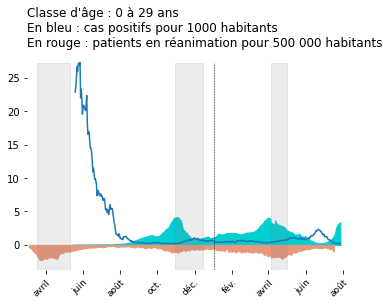

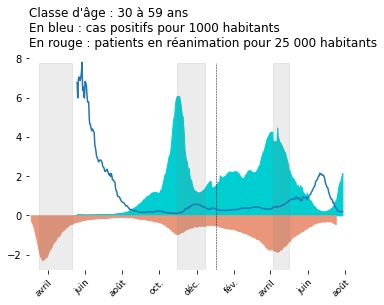

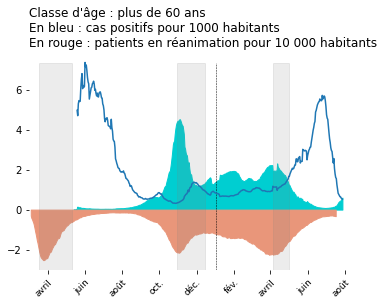

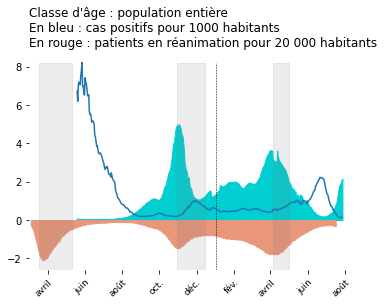

In [96]:
%matplotlib inline
age_class_dict =dict(zip(['0-29', '30-59', '60+', 'whole'], ['0 à 29 ans', '30 à 59 ans', 'plus de 60 ans', 'population entière']))
for age_class, coeff in zip(['0-29', '30-59', '60+', 'whole'], [-500, -25, -10, -20]):
    d = df[(df.entity == 'France') & (df.three_class == age_class)]
    fig, ax = plt.subplots()
    s=ax.spines['top'].set_visible(False)
    s=ax.spines['right'].set_visible(False)
    s=ax.spines['bottom'].set_visible(False)
    s=ax.spines['left'].set_visible(False)
    s=ax.set_xlim(dt.datetime(2020, 3, 1), 
                    dt.datetime(2021, 9, 1))
    s=ax.axvline(dt.datetime(2021, 1, 1), 
                    ymin = 0, ymax = .95, 
                    c = 'black', linewidth = 0.5, linestyle = '--')
    s=ax.axvspan(dt.datetime(2020, 3, 17), 
                    dt.datetime(2020, 5, 10),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2020, 10, 30), 
                    dt.datetime(2020, 12, 15),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2021, 4, 5), 
                    dt.datetime(2021, 5, 2),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    incidence_to_plot = d['incidence hebdo']/100
    s=ax.fill_between(d.jour, incidence_to_plot, color = 'darkturquoise')
    rea_to_plot = d['taux rea']*coeff/100
    s=ax.fill_between(d.jour - pd.Timedelta(14,'D'), rea_to_plot, color = 'darksalmon')
    ratio_to_plot = - rea_to_plot/incidence_to_plot
    s = ax.plot(d.jour, ratio_to_plot)
    s=ax.xaxis.set_tick_params(bottom = True, labelsize = 9)
    xloc = []
    for i in range(9):
        xloc.append(dt.datetime(2020, 4  + 2*i, 1) if 2*i <= 8
                        else dt.datetime(2021, 2*i - 8, 1)
                   )
    labels = ['avril', 'juin', 
                'août', 'oct.', 'déc.', 
                'fév.', 'avril', 
                  'juin','août']
    s=ax.xaxis.set_ticks(xloc)
    s=ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    age_class_txt = age_class_dict[age_class]
    rate_specifier = f'{-1000 * coeff:0,d}'.replace(',', ' ')
    s=plt.title(f'Classe d\'âge : {age_class_txt}\nEn bleu : cas positifs pour 1000 habitants\nEn rouge : patients en réanimation pour {rate_specifier} habitants', loc = 'left')

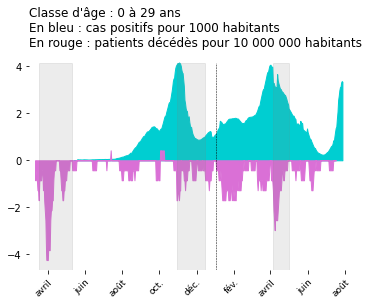

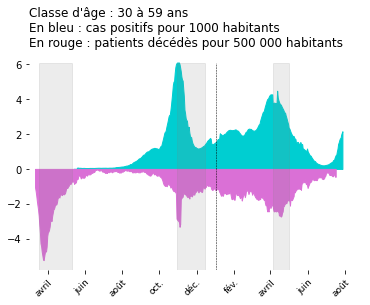

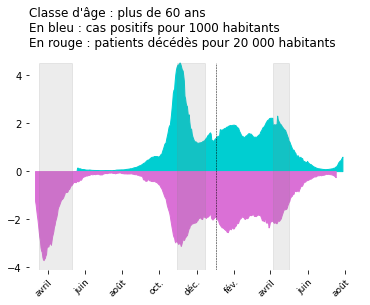

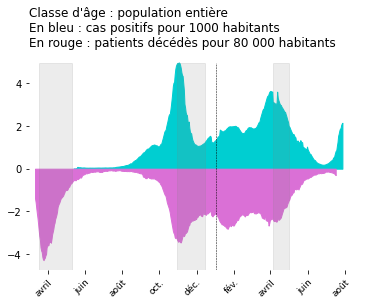

In [93]:
%matplotlib inline
for age_class, coeff in zip(['0-29', '30-59', '60+', 'whole'], [-10000, -500, -20, -80]):
    d = df[(df.entity == 'France') & (df.three_class == age_class)]
    fig, ax = plt.subplots()
    s=ax.spines['top'].set_visible(False)
    s=ax.spines['right'].set_visible(False)
    s=ax.spines['bottom'].set_visible(False)
    s=ax.spines['left'].set_visible(False)
    s=ax.set_xlim(dt.datetime(2020, 3, 1), 
                    dt.datetime(2021, 9, 1))
    s=ax.axvline(dt.datetime(2021, 1, 1), 
                    ymin = 0, ymax = .95, 
                    c = 'black', linewidth = 0.5, linestyle = '--')
    s=ax.axvspan(dt.datetime(2020, 3, 17), 
                    dt.datetime(2020, 5, 10),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2020, 10, 30), 
                    dt.datetime(2020, 12, 15),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.axvspan(dt.datetime(2021, 4, 5), 
                    dt.datetime(2021, 5, 2),
                    ymin = 0, ymax = .95, alpha=0.15, color='gray')
    s=ax.fill_between(d.jour, d['incidence hebdo']/100, color = 'darkturquoise')
    s=ax.fill_between(d.jour - pd.Timedelta(14,'D'), d['taux décès']*coeff/100, color = 'orchid')
    s=ax.xaxis.set_tick_params(bottom = True, labelsize = 9)
    xloc = []
    for i in range(9):
        xloc.append(dt.datetime(2020, 4  + 2*i, 1) if 2*i <= 8
                        else dt.datetime(2021, 2*i - 8, 1)
                   )
    labels = ['avril', 'juin', 
                'août', 'oct.', 'déc.', 
                'fév.', 'avril', 
                  'juin','août']
    s=ax.xaxis.set_ticks(xloc)
    s=ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    age_class_txt = age_class_dict[age_class]
    rate_specifier = f'{-1000 * coeff:0,d}'.replace(',', ' ')
    s=plt.title(f'Classe d\'âge : {age_class_txt}\nEn bleu : cas positifs pour 1000 habitants\nEn rouge : patients décédès pour {rate_specifier} habitants', loc = 'left')

## Figures Type 1

In [15]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)

In [16]:
for label in labels:
    maximum = df[df.entity.isin(dc.regions_metro)][label].max()
    print(label, maximum)

KeyError: 'avril'

#### Fonctions

In [17]:
def order_entities(df, entities, label, age_class):
    """
    reorders entities (regions, départements...) by descending order of the last values of
    label / age_class
    df: dataframe
    regions: list of regions
    label: one of ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo', 'taux de positifs hebdo', 'taux de tests hebdo']
    age_class: one of ['0-29', '30-59', '60+', 'whole']
    regions_ordered: regions ordered accordingly
    """
    jour = df[df[label].notna()].jour.max()
    entities_ordered = (df[(df.jour == jour) 
                            & (df.entity.isin(entities))
                         & (df.three_class == age_class)]
                        .groupby('entity')[label]
                        .mean()
                        .sort_values(ascending = False)
                        .index
                        .tolist()) 

    return entities_ordered

In [18]:
jour = df[df['incidence hebdo'].notna()].jour.max()
jour

Timestamp('2021-07-28 00:00:00')

In [19]:
jour - pd.Timedelta(1,'D')

Timestamp('2021-07-27 00:00:00')

In [20]:
df[(df.jour < jour)].jour.max()

Timestamp('2021-07-27 00:00:00')

In [21]:
pd.Timestamp.now()

Timestamp('2021-08-01 00:05:20.291022')

In [22]:
def time_interval(jour = pd.Timestamp.now(), days = 1):
    period = pd.Timedelta(days, 'D')
    right = jour
    left = pd.Timestamp(jour - period)
    return pd.Interval(left, right)

In [23]:
time_interval()

Interval('2021-07-31 00:05:20.305130', '2021-08-01 00:05:20.305130', closed='right')

In [24]:
def last_value(df, entity, age_class, label):
    jour = df[df[label].notna()].jour.max()
    last_value = (df[(df.jour == jour) 
                    & (df.entity == entity)
                    & (df.three_class == age_class)])[label].values
    return last_value[0]

In [25]:
def max_last_value(entities, age_class, label):
    last_values = []
    for entity in entities:
        last_values.append(last_value(entity, age_class, label))
    return max(last_values)  

In [26]:
df[df.entity.isin(regions_metro)].max(axis = 0)

entity                          Île-de-France
three_class                             whole
jour                      2021-07-31 00:00:00
taux hosp                          371.786941
taux rea                            57.965072
taux décès                          53.833223
taux dose 1                          93.64018
taux complet                        89.205357
population                         12278210.0
incidence hebdo                    1151.92904
taux de positifs hebdo              25.280999
taux de tests hebdo              18005.023745
dtype: object

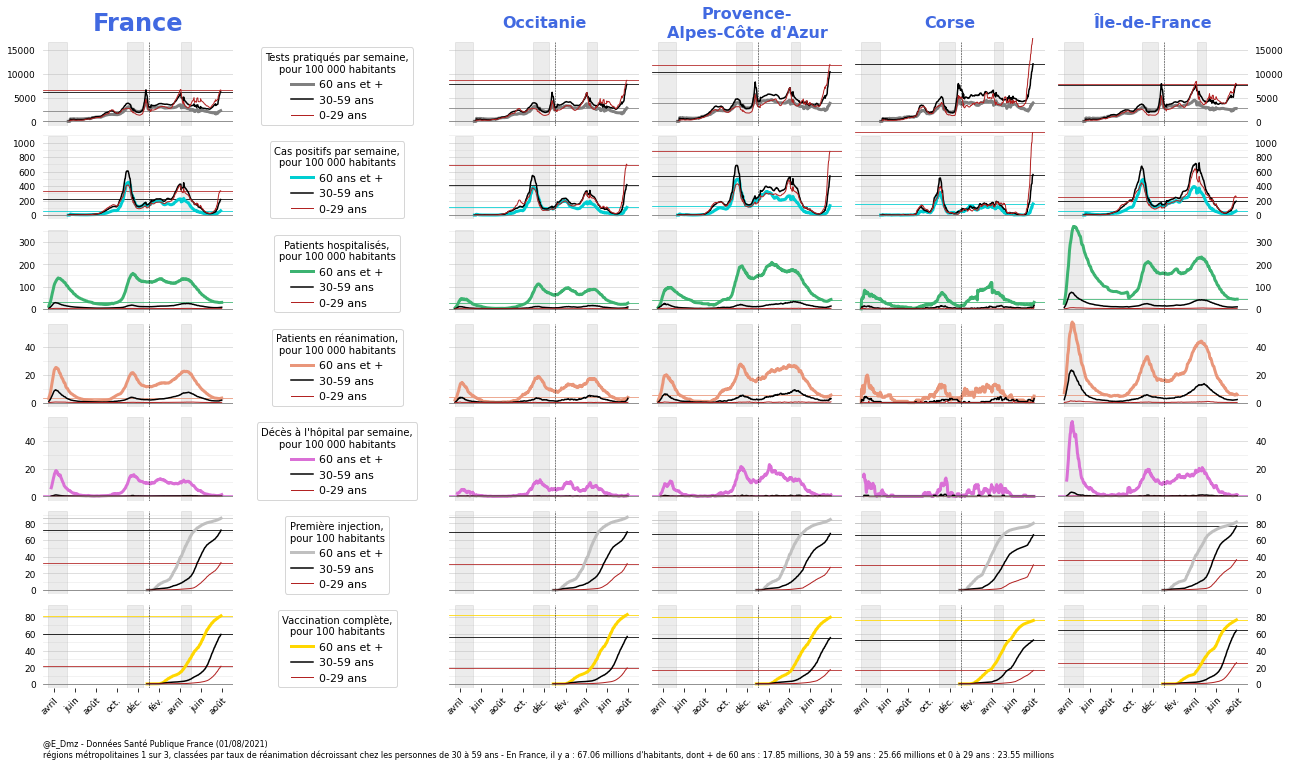

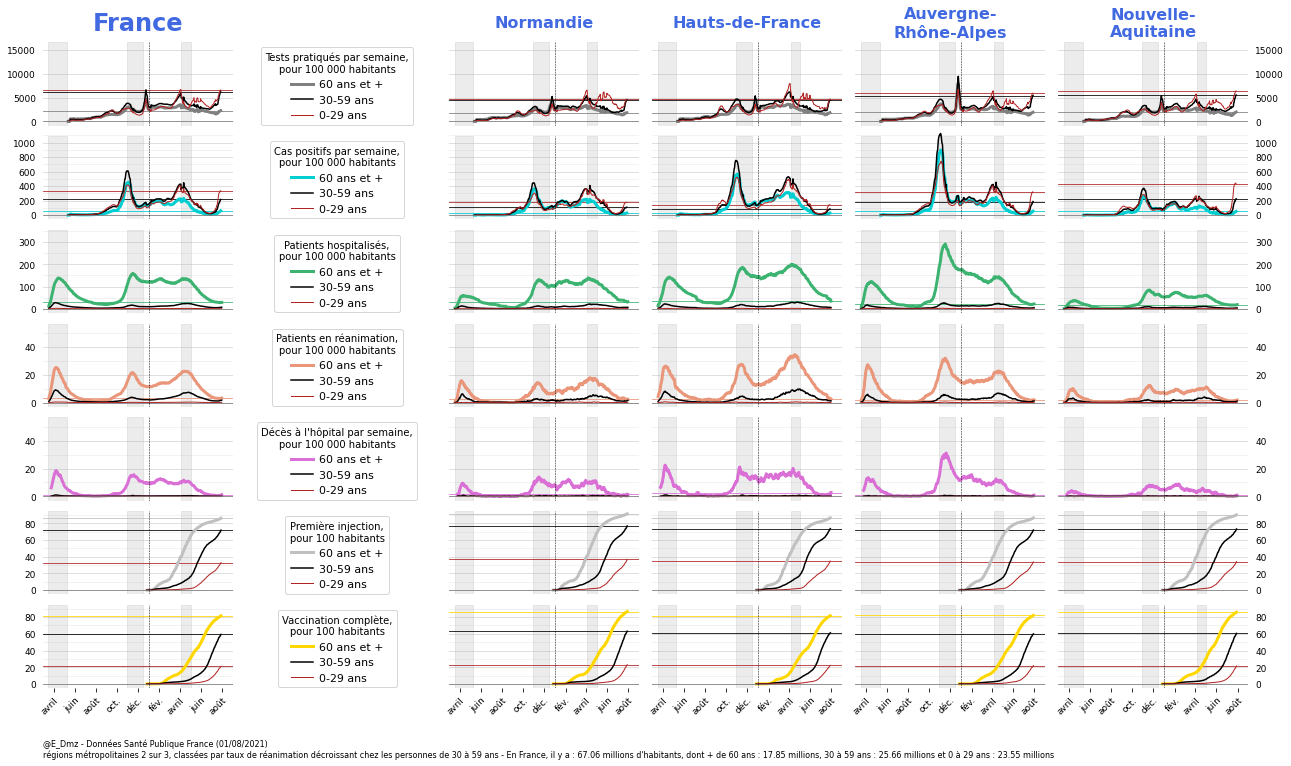

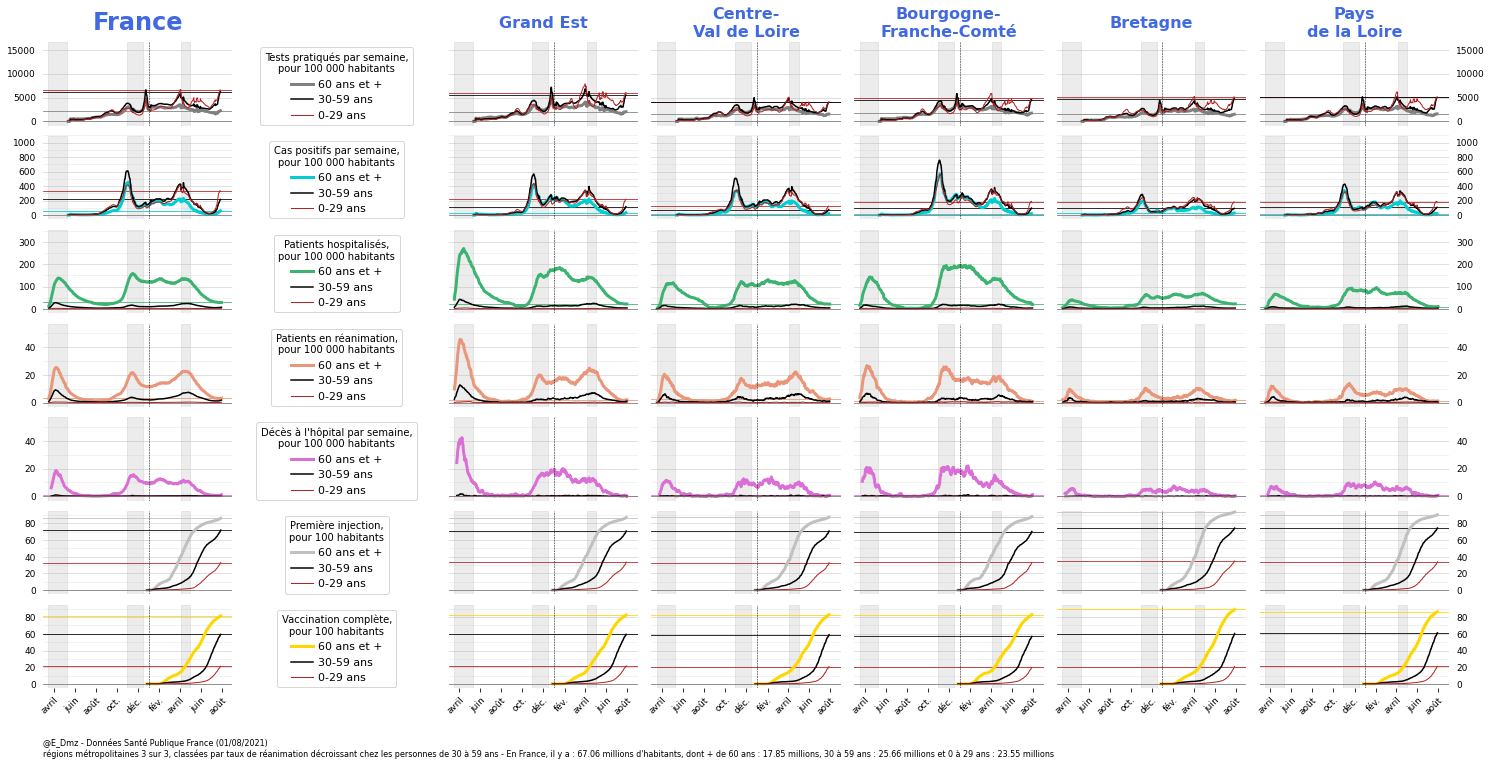

In [27]:
regions_ordered = order_entities(df, regions_metro, 'taux rea', '30-59')
title_begins = 'régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'
graph_options = go.graph_options

gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

### Régions, échelle normale, classées par taux de réa

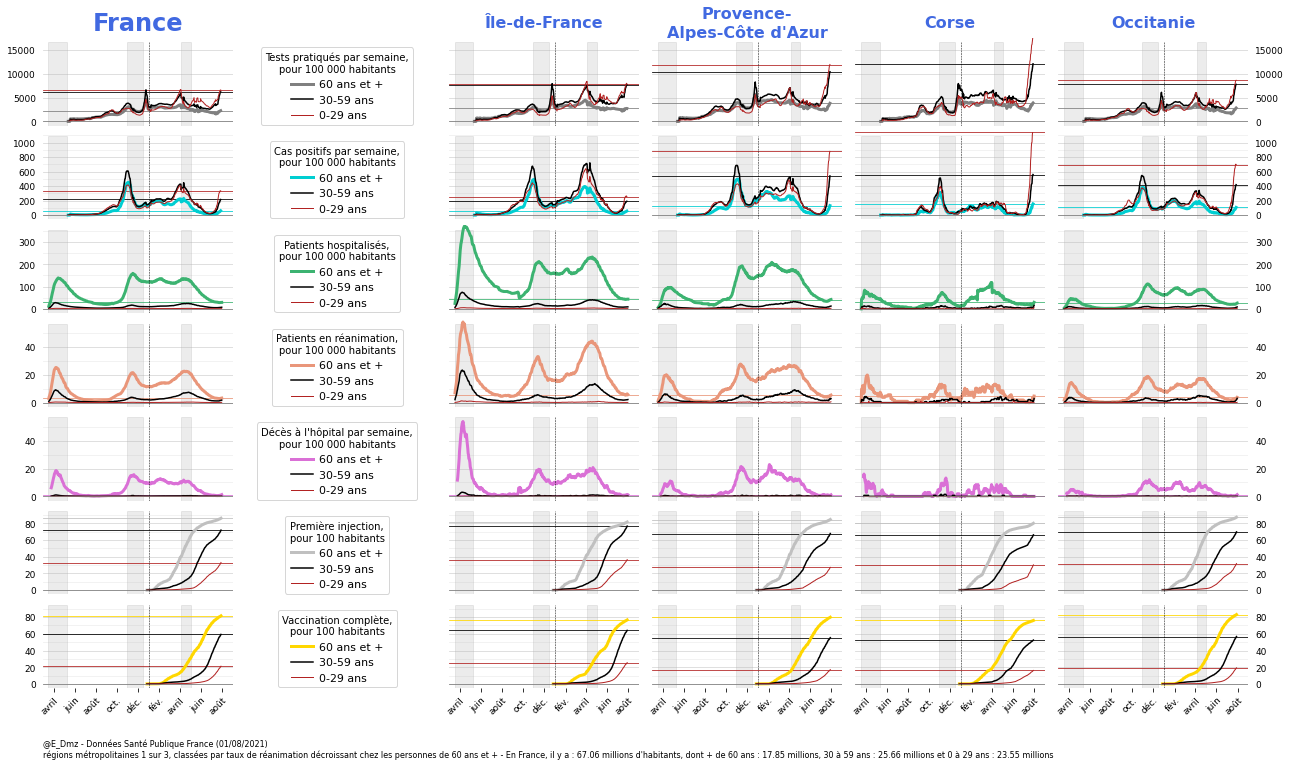

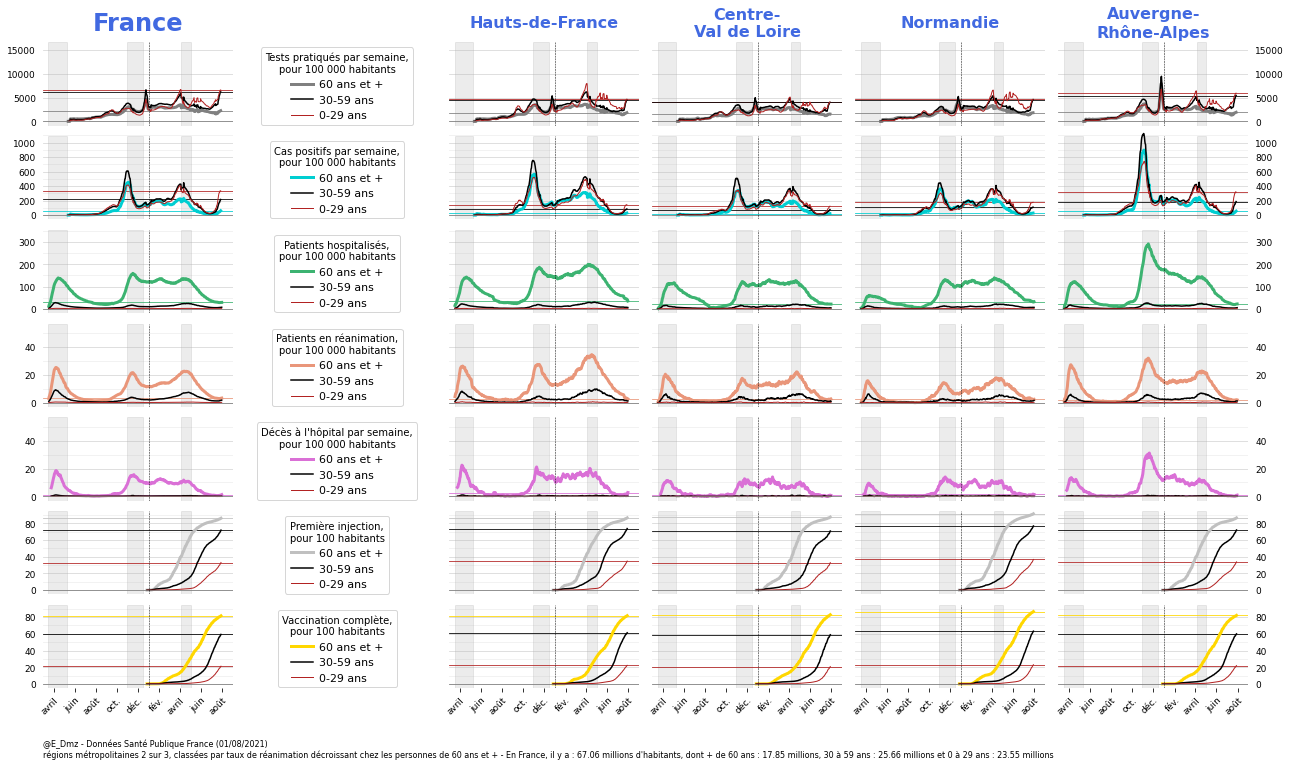

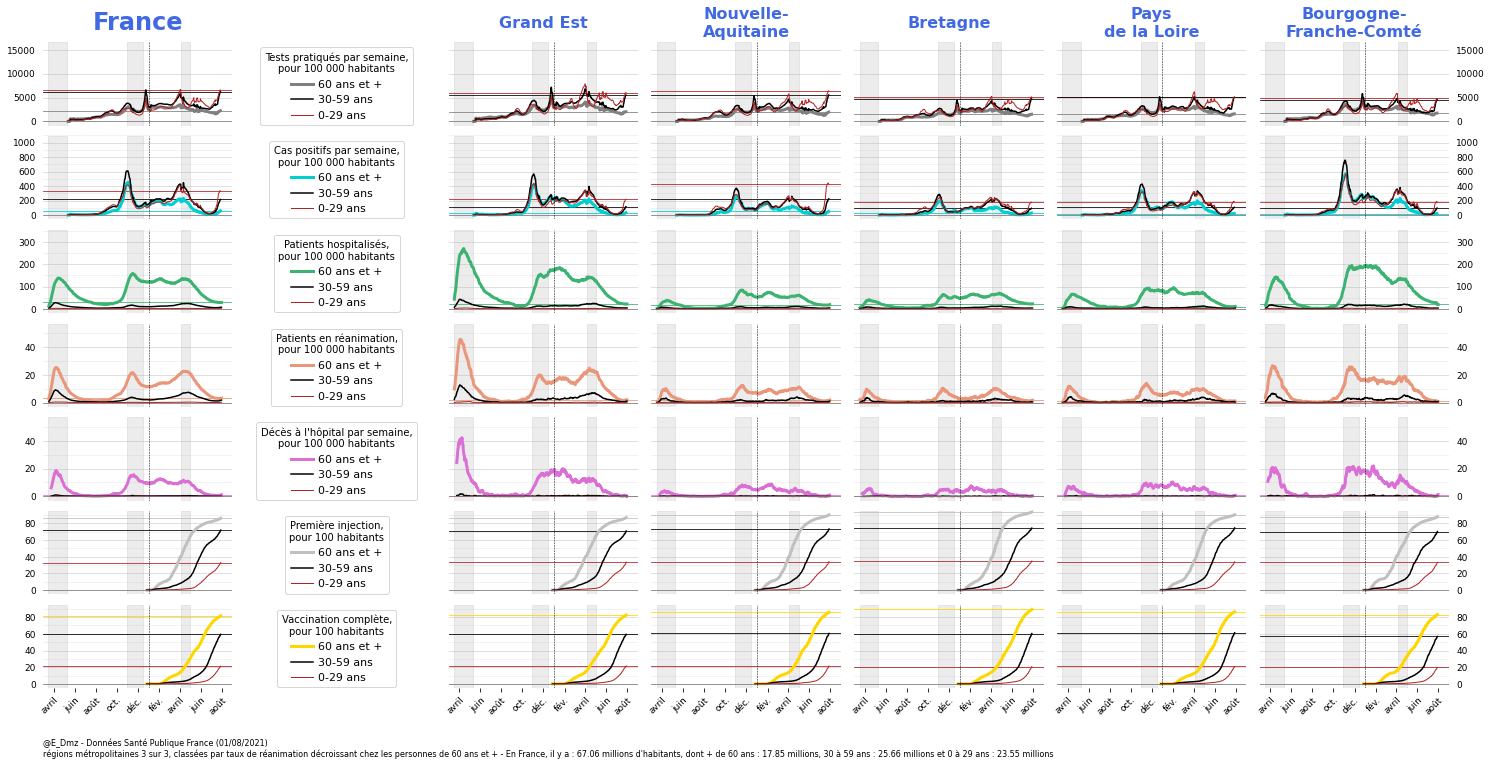

In [28]:
regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
title_begins = 'régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 60 ans et +'
graph_options = go.graph_options

gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

In [29]:
entity = '75'
age_class = '60+' 
label = 'taux complet'
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) ]
last_day = d.jour.max()
d[d.jour == last_day][label].values[0]

81.64272872018728

In [30]:
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) & df[label].notna()]
d

entity three_class       jour  taux hosp  taux rea  taux décès  \
137054     75         60+ 2020-12-27        NaN       NaN         NaN   
137057     75         60+ 2020-12-28        NaN       NaN         NaN   
137060     75         60+ 2020-12-29        NaN       NaN         NaN   
137063     75         60+ 2020-12-30        NaN       NaN         NaN   
137066     75         60+ 2020-12-31        NaN       NaN         NaN   
...       ...         ...        ...        ...       ...         ...   
137684     75         60+ 2021-07-25        NaN       NaN         NaN   
137687     75         60+ 2021-07-26        NaN       NaN         NaN   
137690     75         60+ 2021-07-27        NaN       NaN         NaN   
137693     75         60+ 2021-07-28        NaN       NaN         NaN   
137696     75         60+ 2021-07-29        NaN       NaN         NaN   

        taux dose 1  taux complet  population  incidence hebdo  \
137054     0.002469      0.000000    486118.0       128.981029   
137057     0.005348      0.000000    486118.0       127.746761   
137060     0.006994      0.000000    486118.0       123.632534   
137063     0.013783      0.000000    486118.0       124.455379   
137066     0.018925      0.000000    486118.0       123.426822   
...             ...           ...         ...              ...   
137684    86.737788     80.484574    486118.0        57.393472   
137687    86.943911     80.766193    486118.0        63.153391   
137690    87.214421     81.065503    486118.0        65.827639   
137693    87.456543     81.367281    486118.0        66.444773   
137696    87.712860     81.642729         NaN              NaN   

        taux de positifs hebdo  taux de tests hebdo  
137054                2.361671          5461.431175  
137057                2.527061          5055.151218  
137060                2.777778          4450.771212  
137063                3.132443          3973.109410  
137066                3.455624          3571.766526  
...                        ...                  ...  
137684                1.650204          3477.962141  
137687                1.761836          3584.520631  
137690                1.819836          3617.228739  
137693                1.843081          3605.091768  
137696                     NaN                  NaN  

[215 rows x 12 columns]

### Régions, zoom, classées par incidence chez moins de 30

In [31]:
graph_options_alt_metro = go.scale_graph_by_age_class(df, regions_metro, 
                         ('incidence hebdo', '30-59'),
                         ('taux de tests hebdo', '30-59'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )

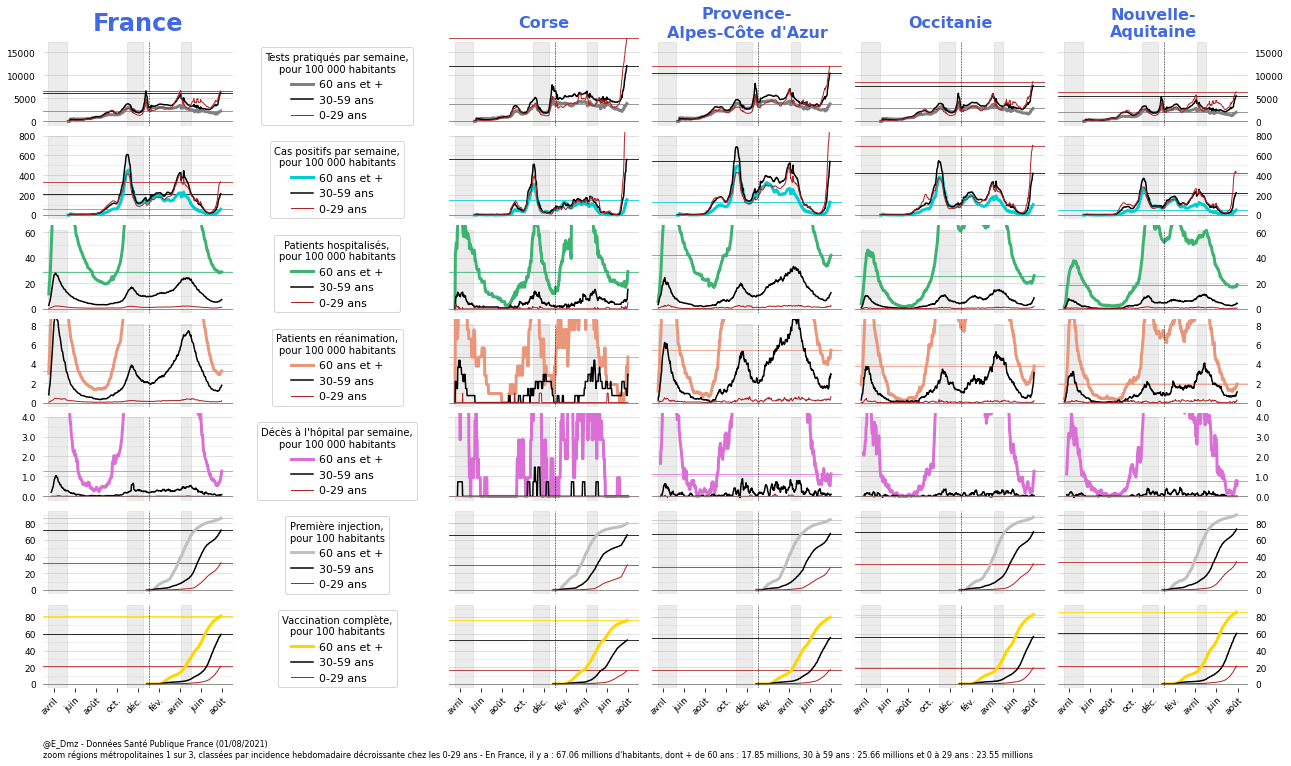

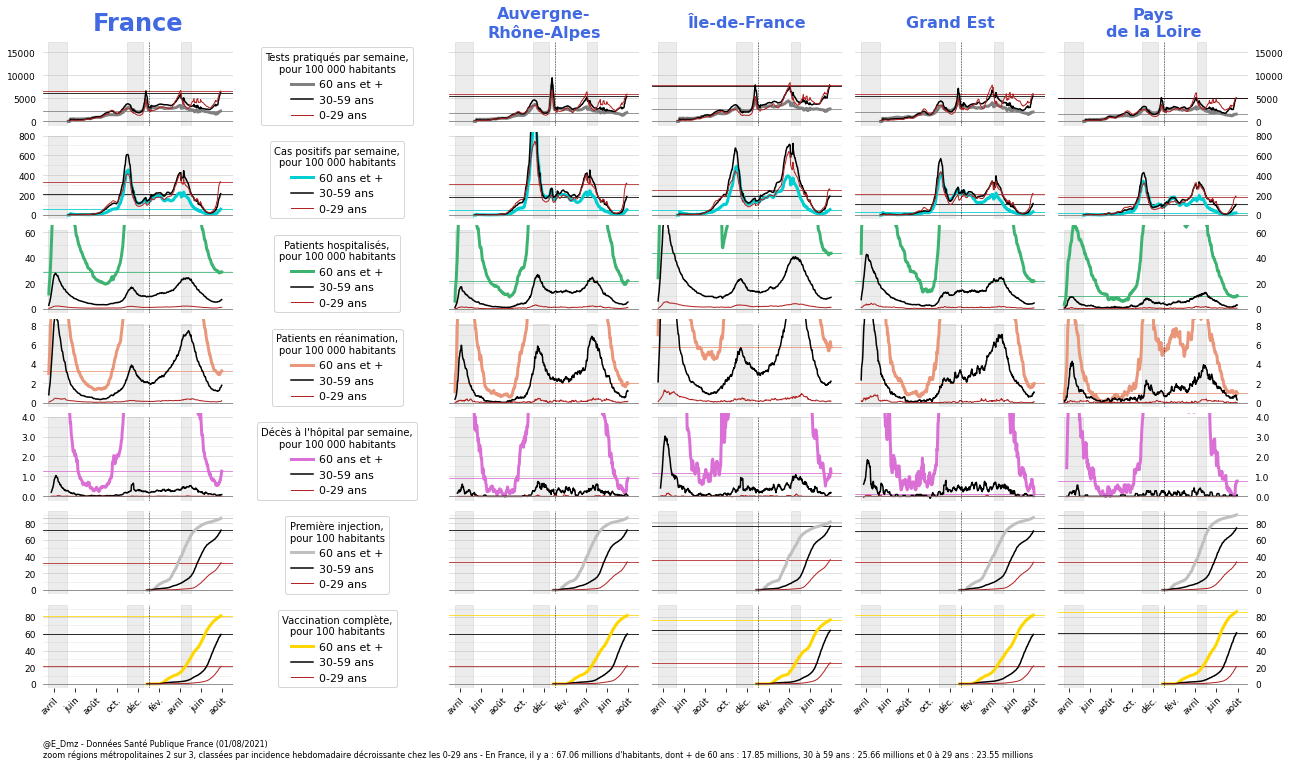

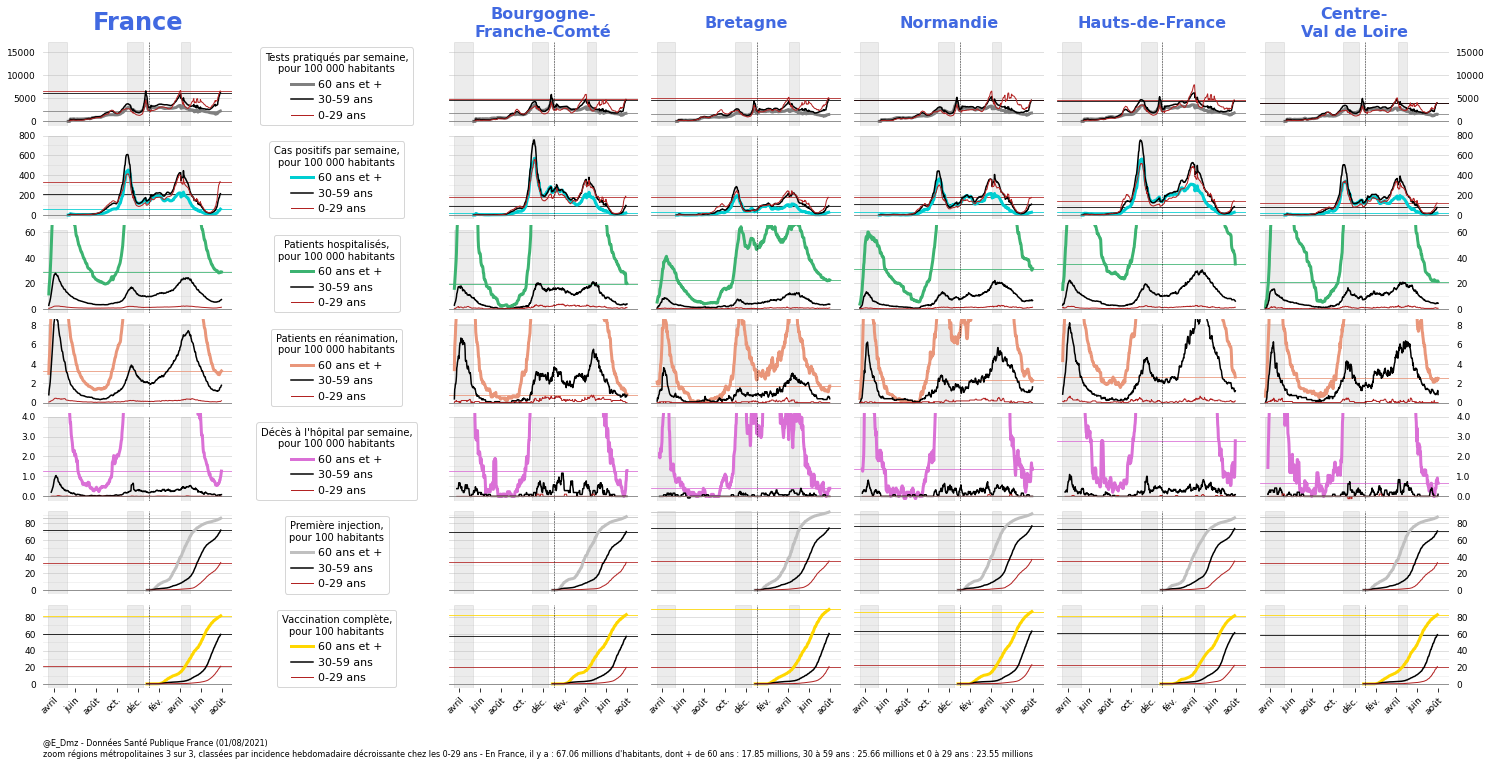

In [32]:
# regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
regions_ordered = order_entities(df, regions_metro, 'incidence hebdo', '0-29')

title_begins = 'zoom régions métropolitaines'
title_ends = 'classées par incidence hebdomadaire décroissante chez les 0-29 ans'

graph_options = graph_options_alt_metro

gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

In [33]:
graph_options_alt_drom = go.scale_graph_by_age_class(df,regions_outre_mer, 
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )

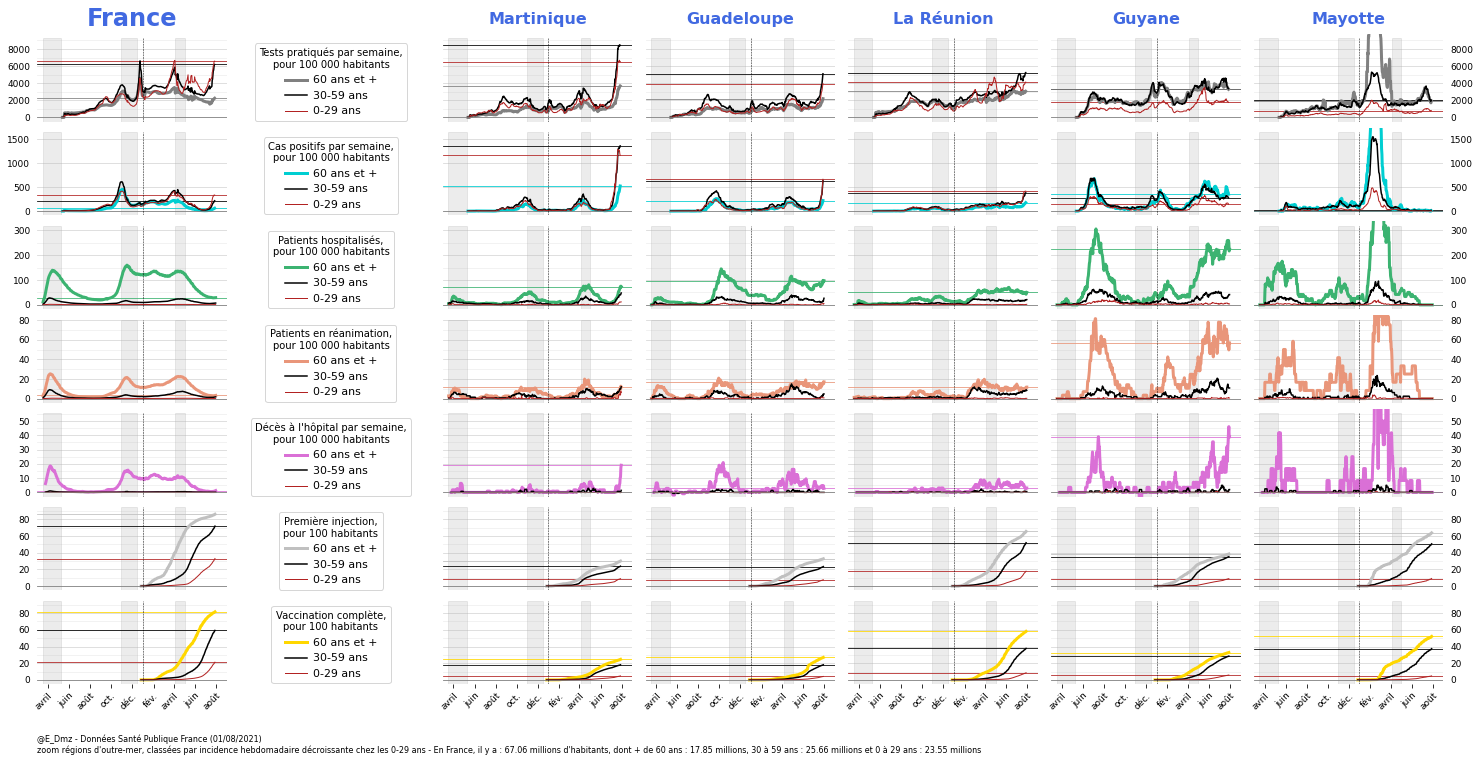

In [34]:
regions_ordered = order_entities(df, regions_outre_mer, 'incidence hebdo', '0-29')

title_begins = 'régions d\'outre-mer'
title_ends = 'classées par incidence hebdomadaire décroissante chez les 0-29 ans'

graph_options = graph_options_alt_drom

title_begins = 'zoom régions d\'outre-mer'
gf.fig_type1(df, regions_ordered, f'{title_begins}, {title_ends}', graph_options)

# Figures Type 0

## France et quelques régions

/home/edmz/DisplayDataCovid/Code/my_package/graph_functions.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize = (8, 4))


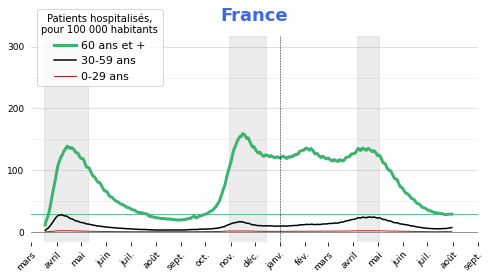

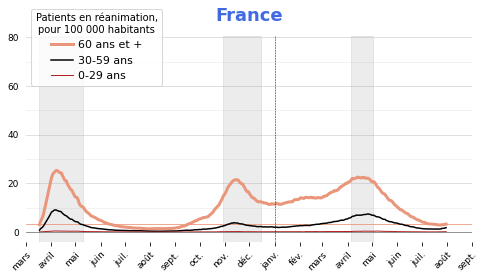

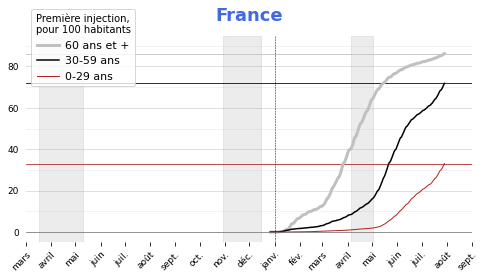

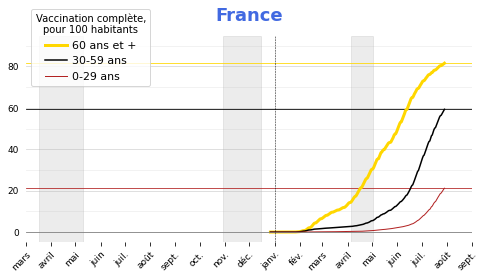

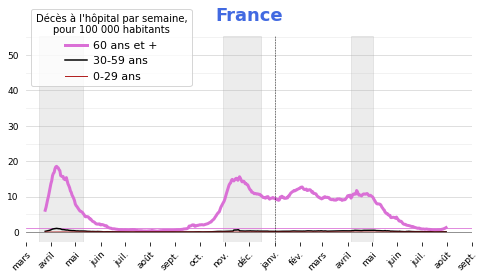

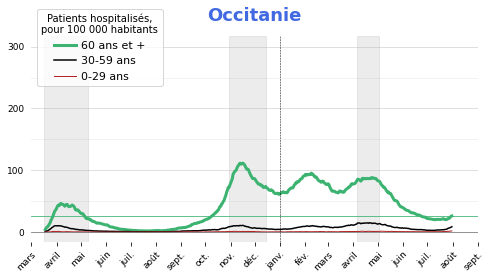

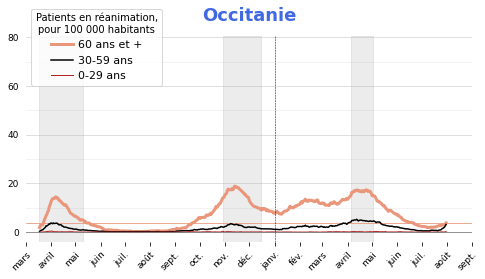

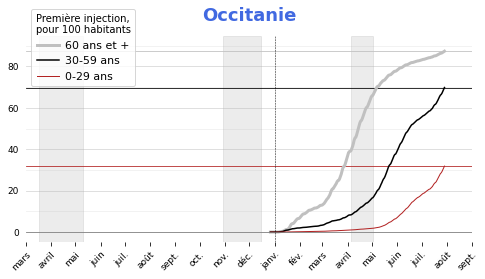

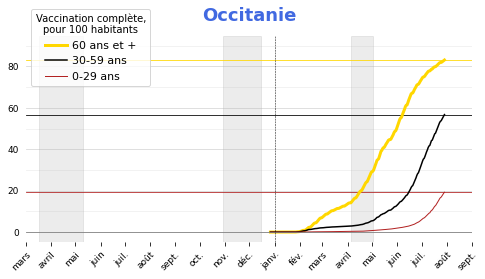

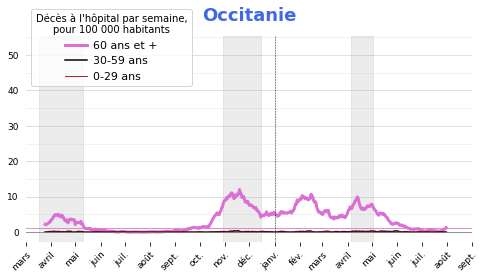

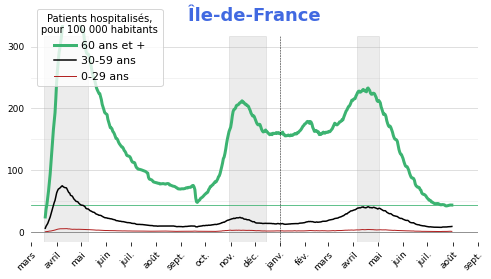

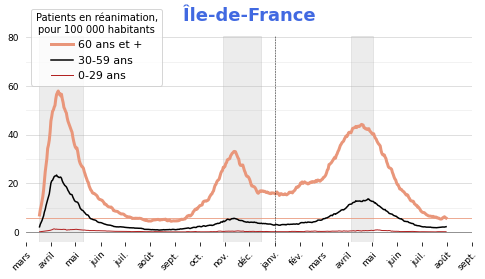

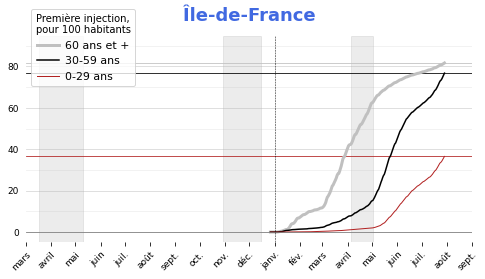

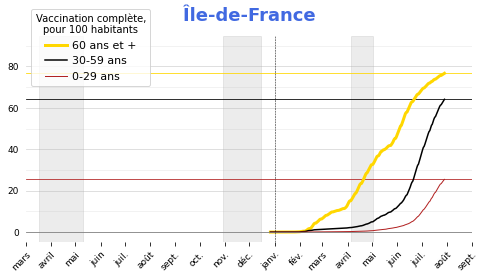

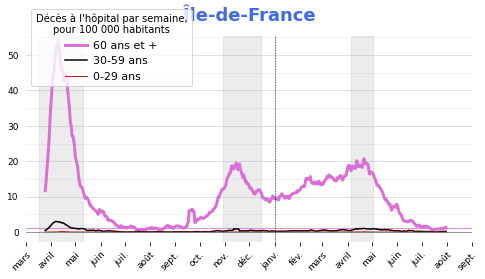

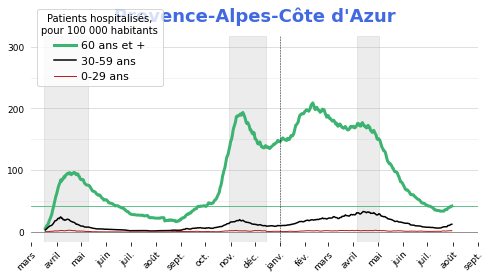

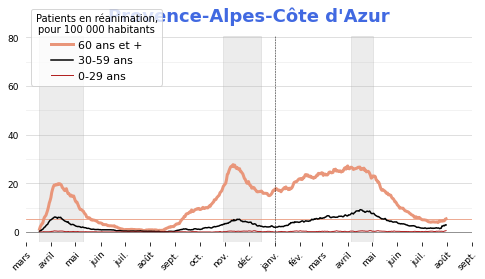

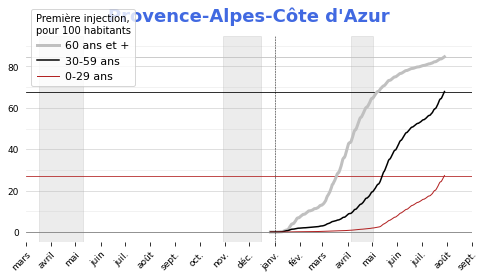

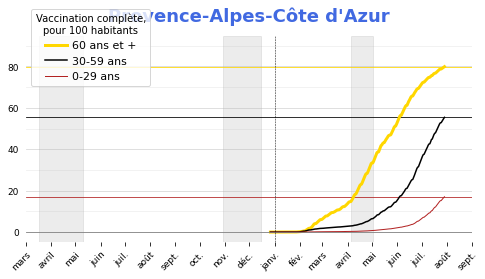

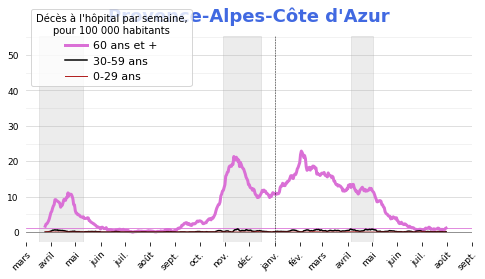

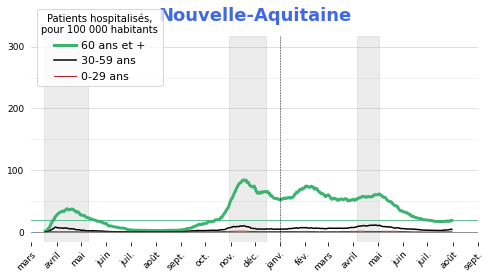

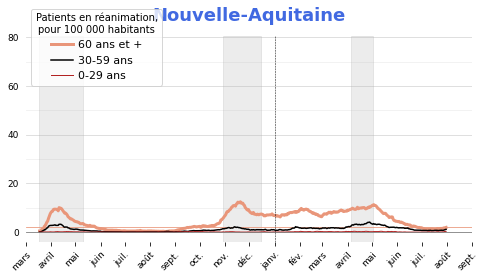

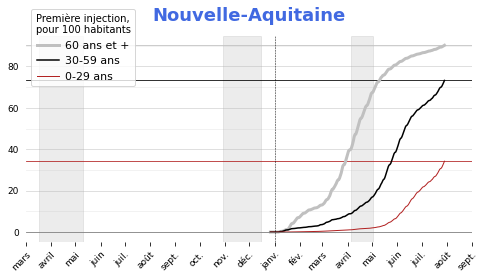

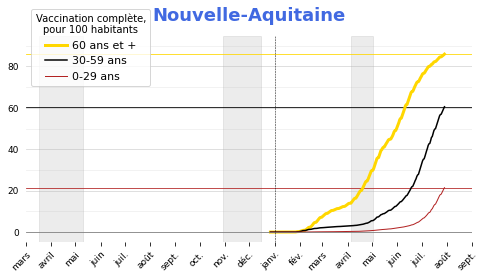

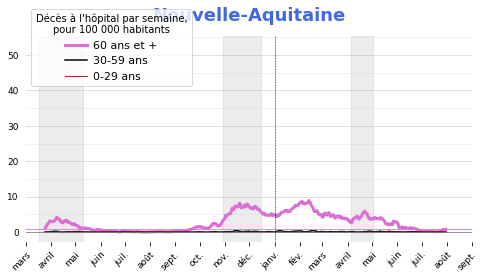

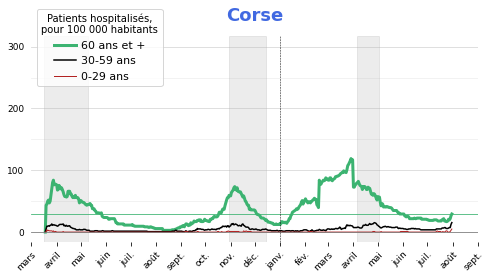

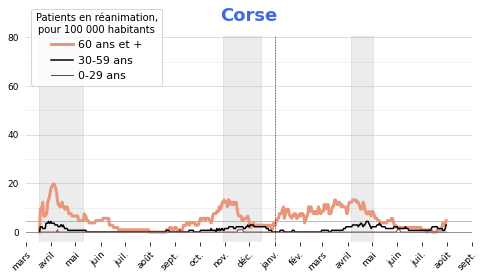

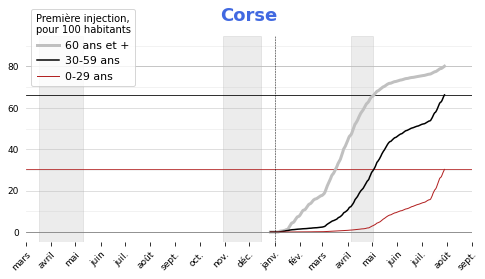

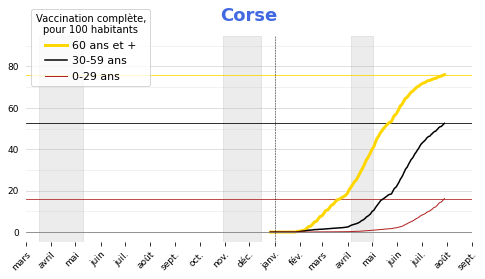

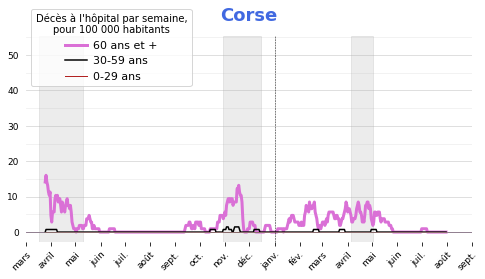

In [35]:
entities = ['France', 'Occitanie', 'Île-de-France', "Provence-Alpes-Côte d'Azur", 'Nouvelle-Aquitaine', 'Corse']
labels = ['taux hosp','taux rea', 'taux dose 1', 'taux complet', 'taux décès']
graph_options = go.graph_options

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)


In [36]:
labels

['taux hosp', 'taux rea', 'taux dose 1', 'taux complet', 'taux décès']

In [37]:
graph_options['taux de positifs hebdo']['ymax'] = 5

In [38]:
graph_options = go.graph_options_auto({'taux de positifs hebdo': 7.5})

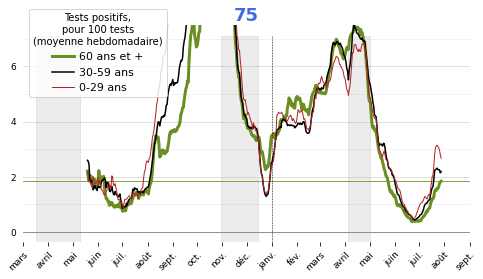

In [39]:
gf.simple_figure(df, '75', 'taux de positifs hebdo', graph_options = graph_options)

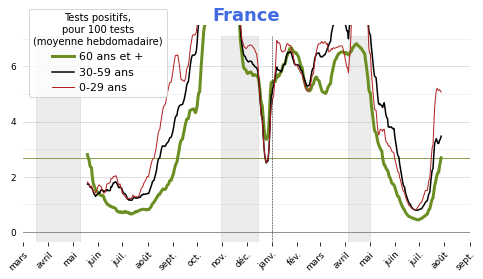

In [40]:
gf.simple_figure(df, 'France', 'taux de positifs hebdo', graph_options = graph_options)

In [41]:
graph_options = go.graph_options_auto({'taux de tests hebdo': 7500})

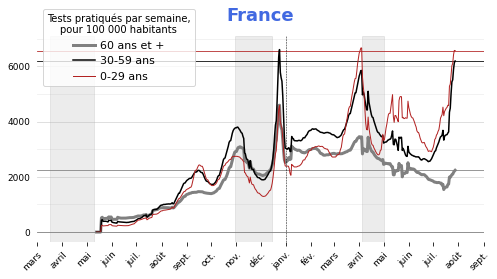

In [42]:
gf.simple_figure(df, 'France', 'taux de tests hebdo', graph_options = graph_options)

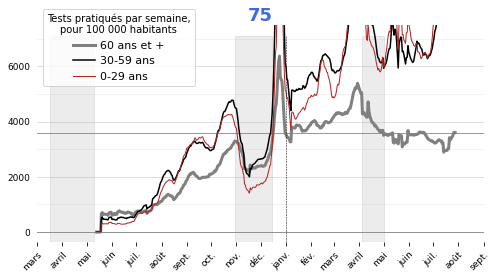

In [43]:
gf.simple_figure(df, '75', 'taux de tests hebdo', graph_options = graph_options)

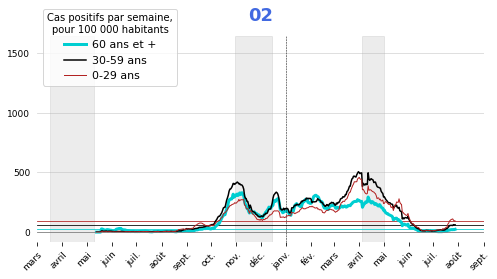

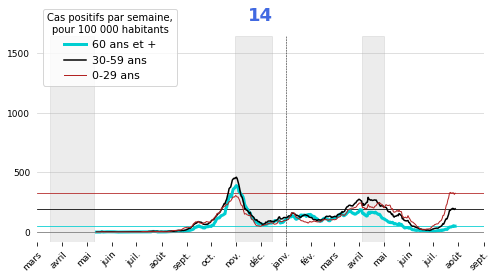

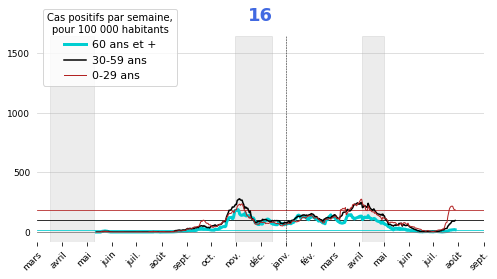

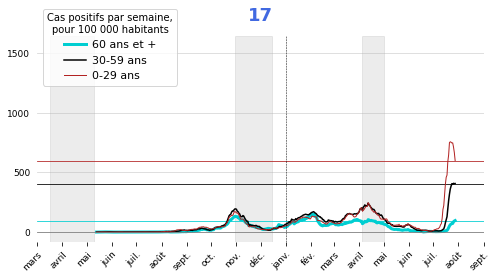

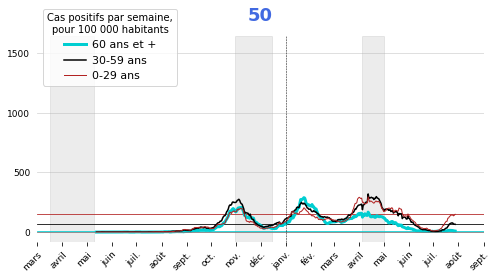

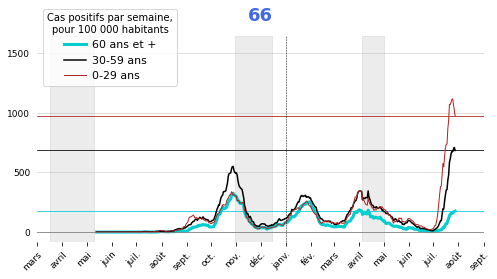

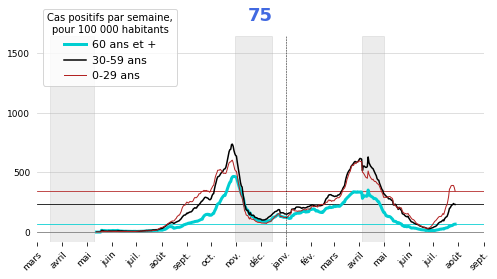

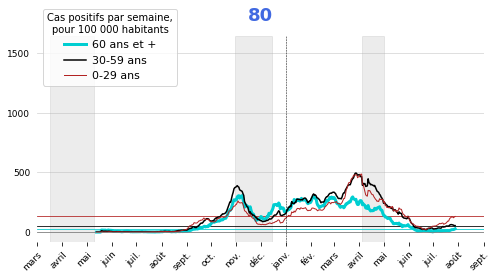

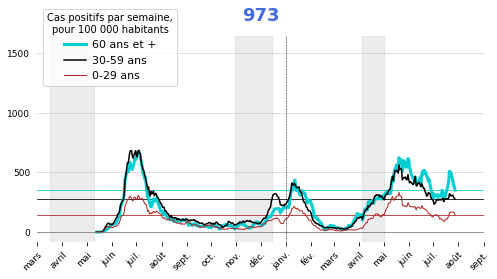

In [44]:
for entity in ['02', '14', '16', '17', '50', '66', '75', '80', '973']:
    gf.simple_figure(df, entity, 'incidence hebdo', graph_options = graph_options)

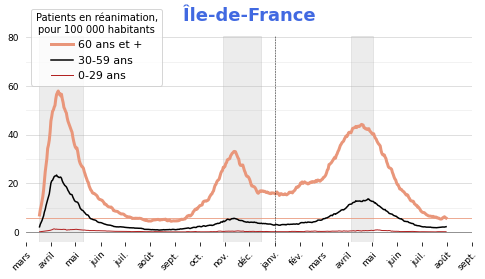

In [45]:
gf.simple_figure(df, 'Île-de-France', 'taux rea', graph_options = graph_options)

## Départements d'Île-de-France

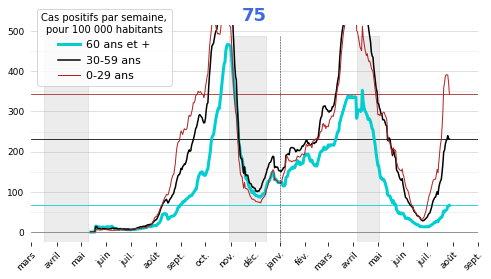

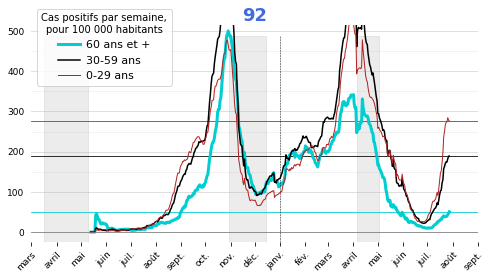

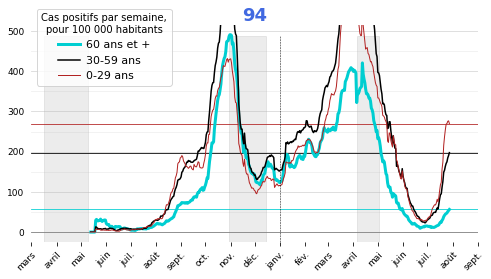

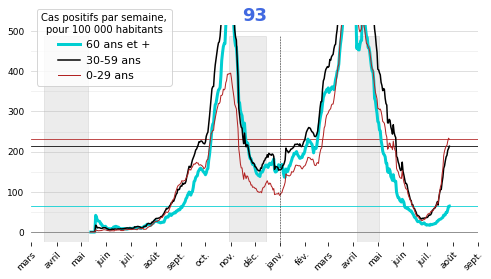

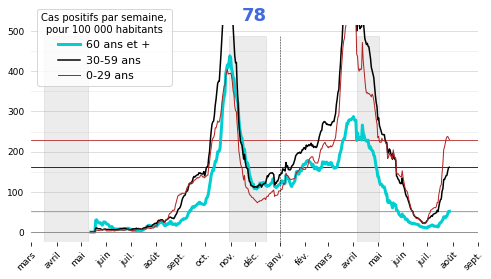

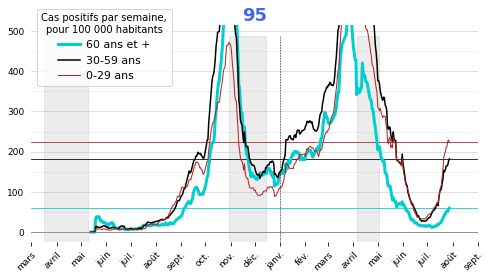

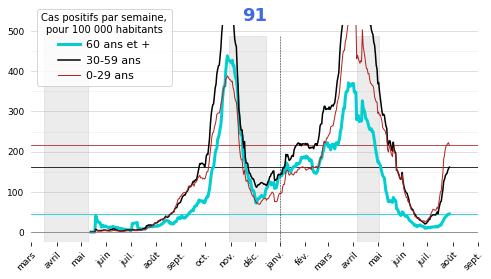

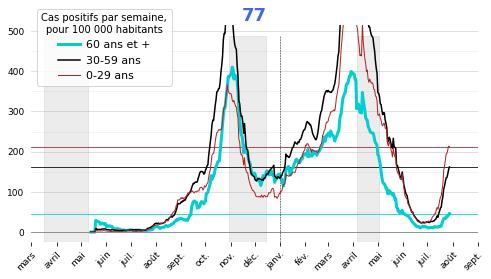

In [46]:
entities = ['75', '93', '92', '94', '91', '95', '77', '78']
graph_options = go.scale_graph_by_age_class(df, entities,
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                        )


entities = order_entities(df, entities, 'incidence hebdo', '0-29')

labels = ['incidence hebdo',]

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)

## Martinique et Guyane

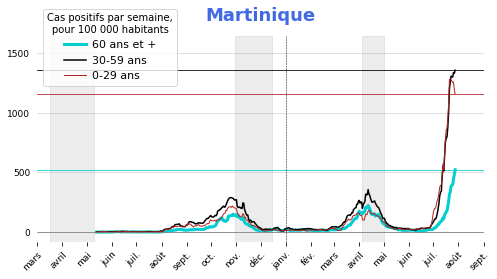

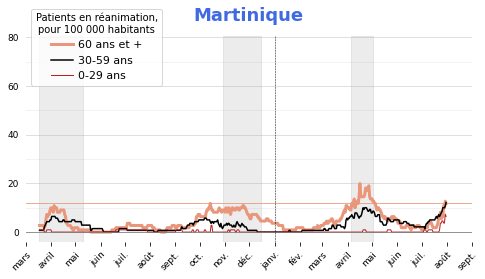

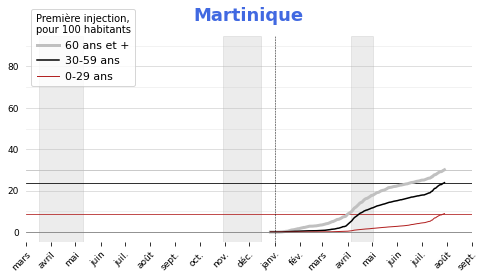

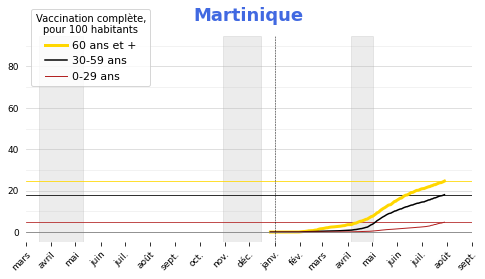

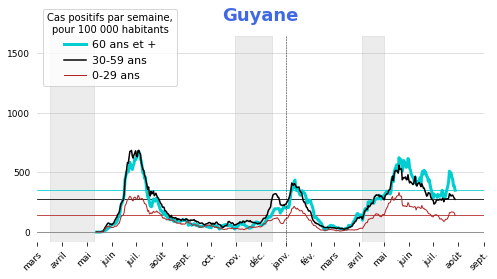

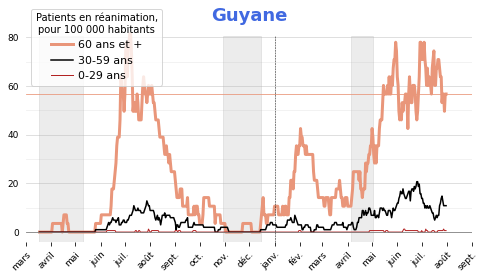

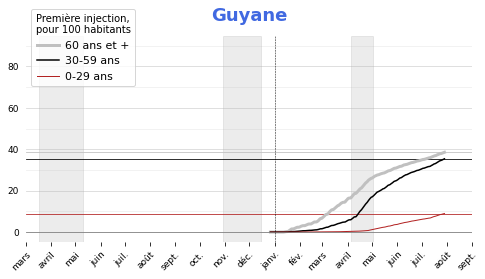

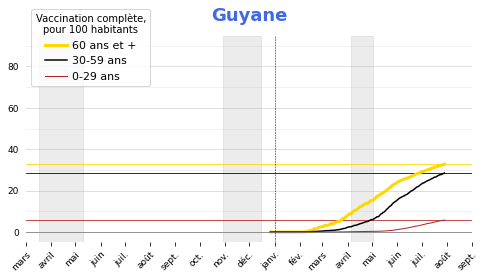

In [47]:
entities = ['Martinique', 'Guyane']
labels = ['incidence hebdo','taux rea', 'taux dose 1', 'taux complet',]
graph_options_alt_drom = go.scale_graph_by_age_class(df,regions_outre_mer, 
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )
graph_options = graph_options_alt_drom

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)
        
toc = time()
time_graph = -tic + toc

In [48]:
regions_metro

['Auvergne-Rhône-Alpes',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre-Val de Loire',
 'Corse',
 'Grand Est',
 'Hauts-de-France',
 'Île-de-France',
 'Normandie',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur"]

In [49]:
graph_options['taux rea']['ymax']= 20
graph_options['taux rea']['majloc'], graph_options['taux rea']['minloc']= go.loc_auto(20)
# graph_options['taux rea']['ymax']= 20



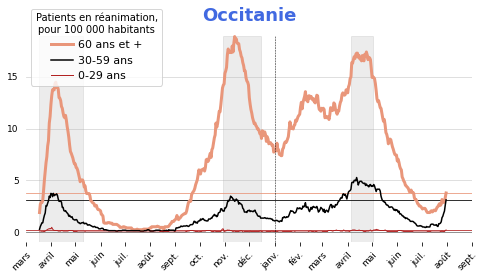

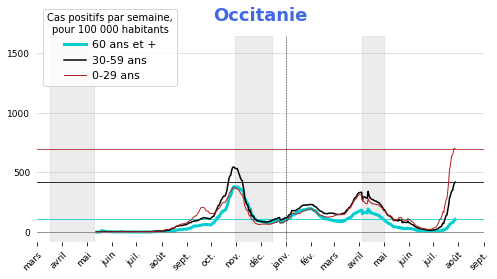

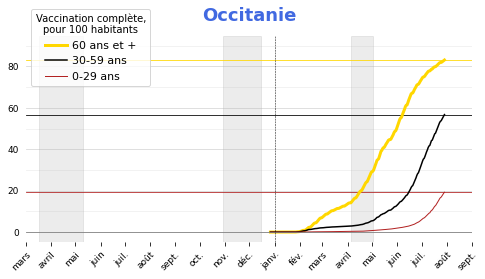

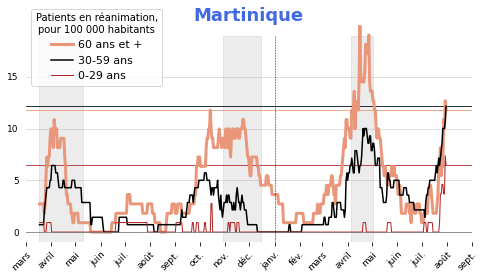

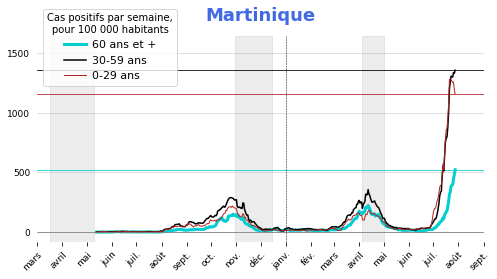

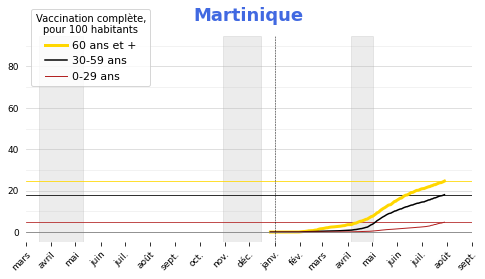

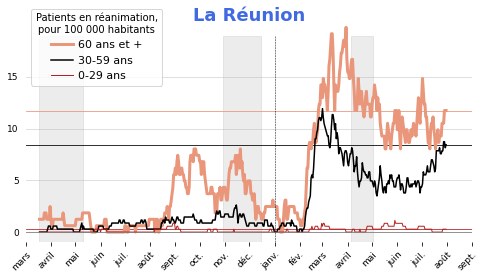

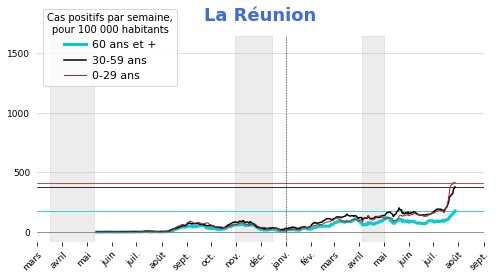

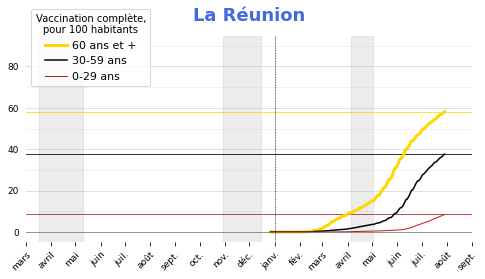

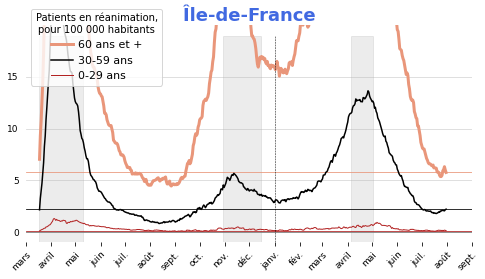

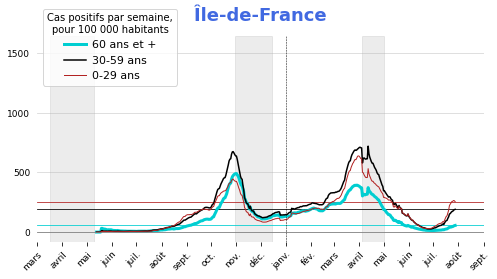

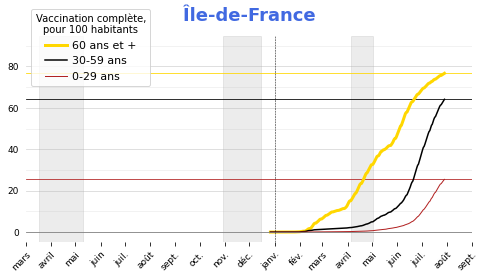

In [50]:
for entity in ['Occitanie', 'Martinique', 'La Réunion', 'Île-de-France']:
    for label in ['taux rea','incidence hebdo', 'taux complet']:
        gf.simple_figure(df, entity, label, graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

# Tweet

In [51]:
import twitter

In [52]:
# from tweets import texts, figures
# tic = time()
# now = dt.datetime.now()
# now_text = now.strftime("%d/%m %H:%M")


# api = twitter.Api(**keys)
# num_tweets = len(texts)









# for i in range(len(tw.texts)):
#     tweet_begins = f'[🤖 MAJ {now_text}]\n' if i == 0 else ''
#     tweet_ends = f'\n{i+1}/{num_tweets}' if i == 0 else f'\n🤖 {i+1}/{num_tweets}'
#     status = api.PostUpdate(
#         f'{tweet_begins}{texts[i]}{tweet_ends}',
#         media = figures[i]
#         )
#     status_0 = status if i = 0 else status_0

# #Tweet 2
# figures = ['France-incidence.png',
# 'France-hosp.png',
# 'France-rea.png',
# 'France-deces.png']
# status = api.PostUpdate(f'{tweets[1]}\n🤖 2/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 3
# figures = ['75-incidence.png',
# '92-incidence.png',
# '93-incidence.png',
# '94-incidence.png']
# status = api.PostUpdate(f'{tweets[2]}\n🤖 3/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )

# #Tweet 4
# figures = ['91-incidence.png',
# '95-incidence.png',
# '77-incidence.png',
# '78-incidence.png']
# status = api.PostUpdate(f'\n🤖 4/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 5
# path_to = path_to_type1
# figures = ['régions métropolitaines 1 sur 3.png',
# 'régions métropolitaines 2 sur 3.png',
# 'régions métropolitaines 3 sur 3.png',
# "régions d'Outre-mer.png"]
# status = api.PostUpdate(f'Comparaison de 7️⃣ indicateurs,\npour 3️⃣ classes d\'âge (0-29, 30-59 et 60+), région par région ⤵️\n(attention : échelles différentes en métropole et dans les outre-mer)\n@SantePubliqueFr @datagouvfr\n🤖 5/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 6
# figures = ['zoom régions métropolitaines 1 sur 3.png',
# 'zoom régions métropolitaines 2 sur 3.png',
# 'zoom régions métropolitaines 3 sur 3.png',
# "zoom régions d'Outre-mer.png"]
# status = api.PostUpdate(f'\n🤖 6/{num_tweets}', 
#                         media = [path_to_type1 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)

# #Tweet 7

# path_to = path_to_type0
# figures = ['Guyane-incidence.png',
# 'Guyane-rea.png',
# 'Martinique-incidence.png',
# 'Martinique-rea.png']
# status = api.PostUpdate(f'\n🤖7/{num_tweets}',
#                         media = [path_to_type0 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)
# #Tweet 8
# figures = ['Guyane-dose1.png',
# 'Guyane-vaccin complet.png',
# 'Martinique-dose1.png',
# 'Martinique-vaccin complet.png']
# status = api.PostUpdate(f'\n🤖8/{num_tweets}',
#                         media = [path_to_type0 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)

# #Tweet 9
# toc = time()
# time_publish = -tic + toc

# status = api.PostUpdate(f'🤖 Pour faire cette MAJ, il m\'a fallu : \n{time_download:.1f} s pour télécharger, \n{time_calculus:.1f} s pour calculer,\n{time_graph:.1f} s pour tracer,\net {time_publish:.1f} s pour publier\n9/{num_tweets}',
#                        in_reply_to_status_id = status.id)

# status = api.PostRetweet(status_0.id)

# Autres graphes

In [53]:

# gf.simple_figure(d, 'Grand Est', 'taux décès')
# gf.simple_figure(d, 'Corse', 'taux complet')
# gf.simple_figure(d, 'Nouvelle-Aquitaine', 'taux rea')
# gf.simple_figure(d, 'Hauts-de-France', 'taux de tests hebdo')

In [54]:
# gf.simple_figure(d, 'France', 'taux hosp')
# gf.simple_figure(d, 'France', 'taux rea')
# gf.simple_figure(d, 'France', 'taux décès')

In [55]:
# gf.simple_figure(d, 'Mayotte', 'incidence hebdo')
# gf.simple_figure(d, 'Mayotte', 'taux rea')
# gf.simple_figure(d, '976', 'incidence hebdo')

In [56]:
# gf.simple_figure(d, 'Guyane', 'taux hosp')
# gf.simple_figure(d, 'Guyane', 'taux rea')
# gf.simple_figure(d, 'Guyane', 'taux décès')
# gf.simple_figure(d, '973', 'taux dose 1')
# gf.simple_figure(d, '973', 'taux complet')


In [57]:
# gf.simple_figure(d, '973', 'incidence hebdo')
# gf.simple_figure(d, '93', 'incidence hebdo')
# gf.simple_figure(d, '971', 'incidence hebdo')

# gf.simple_figure(d, '971', 'incidence hebdo')

In [58]:
# gf.simple_figure(d, 'France', 'incidence hebdo')
# gf.simple_figure(d, 'Île-de-France', 'incidence hebdo')
# gf.simple_figure(d, '75', 'incidence hebdo')
